## Evaluating Pre-Trained CNN model
<br>
<br>

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os
from scripts import engine,predictions,train
import matplotlib.pyplot as plt
from src.models import resnet
from src.data import dataloaders,transforms
from src.utils import visualisations,save_model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## ResNet-50

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_WORKERS = os.cpu_count()
EPOCHS = 10

In [7]:
ResNet50, resnet50_eval_transforms = resnet.resnet50(num_classes=10)

In [8]:
resnet50_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

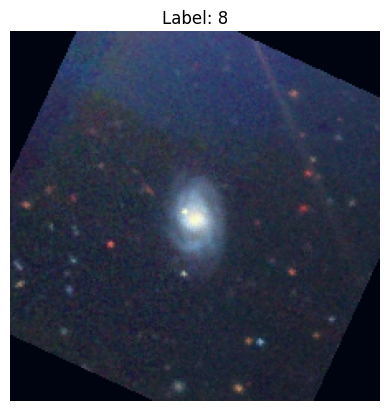

In [10]:
import matplotlib.pyplot as plt

# Get one batch
img_batch, label_batch = next(iter(train_loader))

# Pick first sample
img = img_batch[0]
label = label_batch[0]

# If tensor is normalized, bring it back to [0, 1] for visualization
img = img.permute(1, 2, 0).cpu()

img = img - img.min()
img = img / img.max()

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [11]:
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
resnet50_results = engine.train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7421 | train_acc: 0.3977 | val_loss: 1.5684 | val_acc: 0.4602
Epoch: 2 | train_loss: 1.5085 | train_acc: 0.4733 | val_loss: 1.4888 | val_acc: 0.4678
Epoch: 3 | train_loss: 1.4459 | train_acc: 0.4854 | val_loss: 1.4560 | val_acc: 0.4821
Epoch: 4 | train_loss: 1.4177 | train_acc: 0.4958 | val_loss: 1.4016 | val_acc: 0.5163
Epoch: 5 | train_loss: 1.3935 | train_acc: 0.5027 | val_loss: 1.3872 | val_acc: 0.5131
Epoch: 6 | train_loss: 1.3836 | train_acc: 0.5036 | val_loss: 1.3720 | val_acc: 0.5231
Epoch: 7 | train_loss: 1.3832 | train_acc: 0.5042 | val_loss: 1.3485 | val_acc: 0.5296
Epoch: 8 | train_loss: 1.3666 | train_acc: 0.5120 | val_loss: 1.3462 | val_acc: 0.5429
Epoch: 9 | train_loss: 1.3680 | train_acc: 0.5141 | val_loss: 1.3272 | val_acc: 0.5525
Epoch: 10 | train_loss: 1.3602 | train_acc: 0.5077 | val_loss: 1.3417 | val_acc: 0.5479


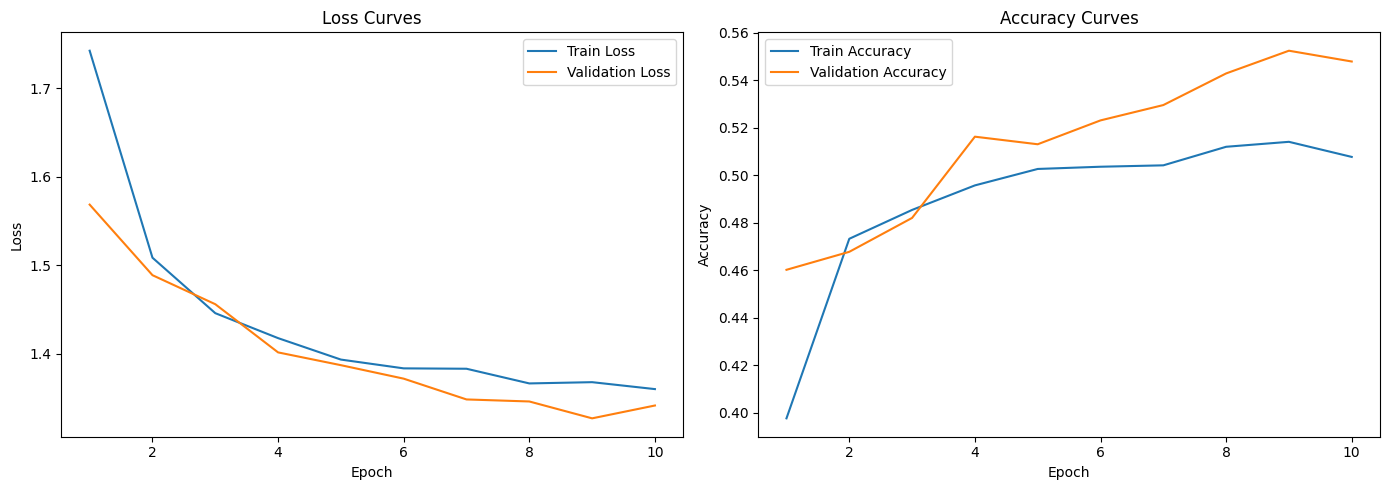

In [13]:
visualisations.plot_acc_loss_curves(results=resnet50_results,validation=True)

In [ ]:
# save_model.save_model(model=ResNet50,model_name="Resnet50_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_10_epochs_trainable_classifier.pth


In [ ]:
# ResNet50, _ = resnet.resnet50(num_classes=10)

# ResNet50.load_state_dict(torch.load(f="../checkpoints/resnet50/Resnet50_10_epochs_trainable_classifier.pth"))

<All keys matched successfully>

In [26]:
test_results = predictions.test_model(model=ResNet50,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5135
Test loss : 1.4031


In [ ]:
len(test_results["predictions"])

1774

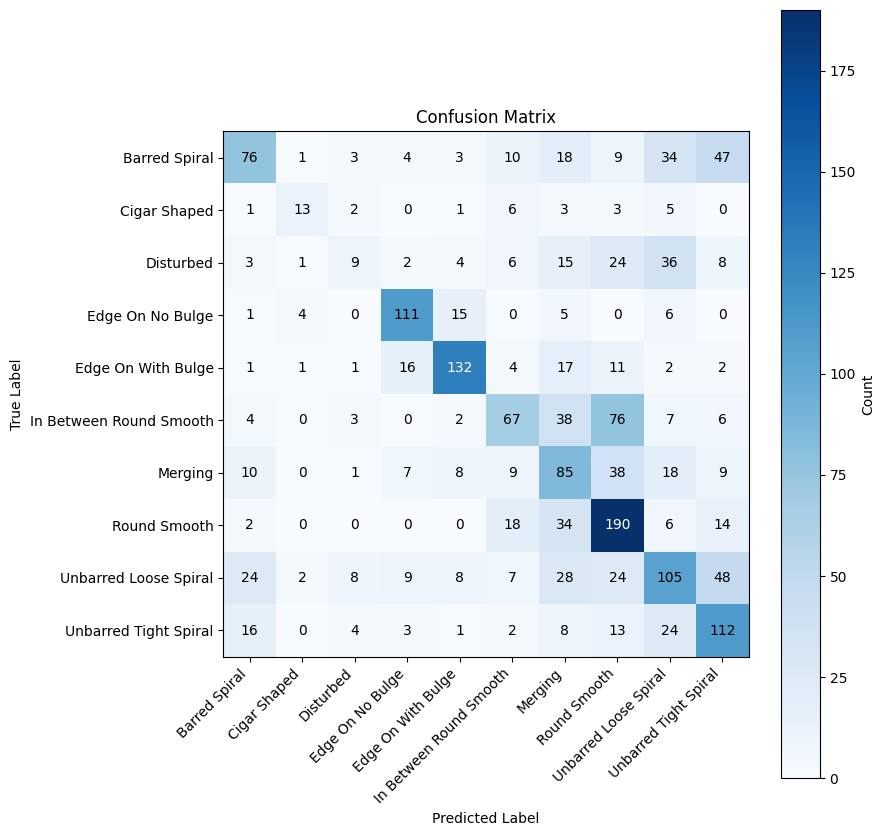

In [16]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

## ResNet26

In [17]:
ResNet26, resnet26_eval_transforms = resnet.resnet26(num_classes=10)

In [18]:
resnet26_eval_transforms

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [19]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [22]:
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
resnet26_results = engine.train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5208 | train_acc: 0.4583 | val_loss: 1.4923 | val_acc: 0.4762
Epoch: 2 | train_loss: 1.3581 | train_acc: 0.5155 | val_loss: 1.4214 | val_acc: 0.4943
Epoch: 3 | train_loss: 1.3211 | train_acc: 0.5266 | val_loss: 1.4560 | val_acc: 0.4707
Epoch: 4 | train_loss: 1.3006 | train_acc: 0.5362 | val_loss: 1.3955 | val_acc: 0.4888
Epoch: 5 | train_loss: 1.2874 | train_acc: 0.5335 | val_loss: 1.3726 | val_acc: 0.5033
Epoch: 6 | train_loss: 1.2810 | train_acc: 0.5393 | val_loss: 1.3669 | val_acc: 0.5182
Epoch: 7 | train_loss: 1.2907 | train_acc: 0.5347 | val_loss: 1.3797 | val_acc: 0.4950
Epoch: 8 | train_loss: 1.2712 | train_acc: 0.5421 | val_loss: 1.3634 | val_acc: 0.5183
Epoch: 9 | train_loss: 1.2734 | train_acc: 0.5443 | val_loss: 1.3482 | val_acc: 0.5139
Epoch: 10 | train_loss: 1.2769 | train_acc: 0.5479 | val_loss: 1.3417 | val_acc: 0.5117


In [27]:
test_results = predictions.test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5023
Test loss : 1.3589


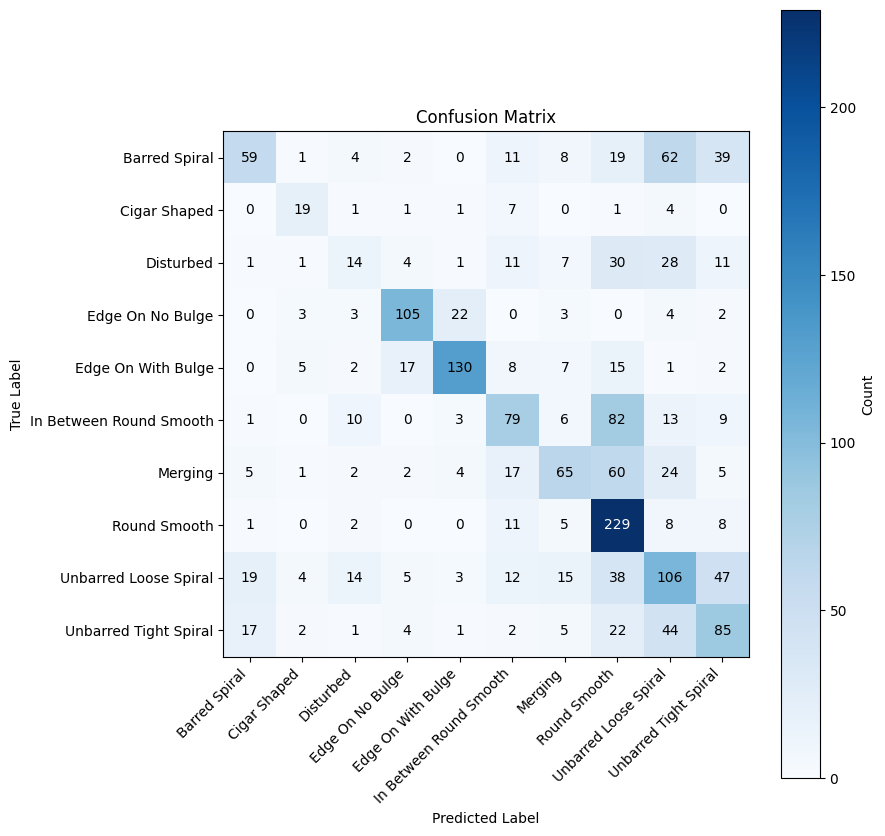

In [28]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)